# Setup

In [6]:
# handle math and data
import numpy as np
import pandas as pd

# to plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# handle files
import os
import joblib

SEED = 69

# Load MNIST Dataset

We want to do the following:
- Load MNIST from openml using sklearn
- Get an idea of the data (like size, features, data types)
- Split dataset into train (60K) and test (10K)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

MNIST is preprocessed, but we do need to convert the y to ints.

In [3]:
type(y[0])

str

In [4]:
y = y.astype(np.int8)

Now split it into train and test sets.

In [5]:
train_size = 60000

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

Good

# Train Models

## No PCA

Just train a regular `RandomForestClassifier` on the training set and evaluate on test set.

In [46]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=SEED, verbose=1)

In [47]:
forest_clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 30.4 s, sys: 310 ms, total: 30.7 s
Wall time: 31.1 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   30.9s finished


RandomForestClassifier(random_state=69, verbose=1)

It took `30.5 seconds` to train our random forest. Now let's evaluate it on the test set.

In [9]:
forest_clf.score(X_test, y_test)

0.9691

This is a decent accuracy. Let's try with PCA dimensionality reduction now.

## PCA 95% Variance

Now we need to do the following:
- Reduce X_train using PCA and preserve 95% variance
    - Play around with PCA and explore fields and params
- Train another RandomForestClassifier on the reduced X_train
- Evaluate on test set

### Applying PCA

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=SEED)

In [11]:
%%time
pca.fit(X_train)

CPU times: user 9.08 s, sys: 631 ms, total: 9.71 s
Wall time: 3.15 s


PCA(n_components=0.95, random_state=69)

We are just fitting, it didn't take too long. Now let's explore some attributes of PCA.

In [12]:
pca.n_components_

154

This matches with what I saw in the book.

In [13]:
pca.n_features_

784

In [17]:
pca.components_.shape

(154, 784)

So when we apply transform we would multiply X by the transpose of `pca.components_`
- The resulting matrix of (60000, 784) dot (784, 154) would be (60000, 154)

We can test if this is true.

In [31]:
our_X_train_centered = X_train - X_train.mean(axis=0)
our_X_train_reduced = our_X_train_centered.dot(pca.components_.T)
our_X_train_reduced.shape

(60000, 154)

In [32]:
X_train_reduced = pca.transform(X_train)
X_train_reduced.shape

(60000, 154)

In [33]:
our_X_train_reduced[0, :3]

array([ 123.93258866, -312.67426202,  -24.51405176])

In [34]:
X_train_reduced[0, :3]

array([ 123.93258866, -312.67426202,  -24.51405176])

See? They are the same! :>

In [35]:
del our_X_train_centered
del our_X_train_reduced

Ok let's move on.

Now let's train a new `RandomForestClassifier` on our reduced training data with only 154 features.

### Training on Reduced Data

In [41]:
reduced_forest_clf = RandomForestClassifier(n_estimators=100, random_state=SEED, verbose=1)

In [45]:
reduced_forest_clf.fit(X_train_reduced, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1min 20s, sys: 642 ms, total: 1min 21s
Wall time: 1min 22s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestClassifier(random_state=69, verbose=1)

Wow! Surprisingly this took a longer `1min 19s`!

Perhaps this has to do with using random forest.

Let's first evaluate the model before digging deeper.

In [49]:
X_test_reduced = pca.transform(X_test)

reduced_forest_clf.score(X_test_reduced, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.9498

It took longer, and the score on the test set is lower.

Let's try a different model!

## Not Random Forest

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_clf = KNeighborsClassifier()

pca_knn_clf = Pipeline([
    ("pca", PCA(n_components=0.95)),
    ("knn_clf", KNeighborsClassifier()),
])

In [64]:
%%time
knn_clf.fit(X_train, y_train)

CPU times: user 32.5 ms, sys: 1.93 ms, total: 34.4 ms
Wall time: 31.8 ms


KNeighborsClassifier()

In [65]:
%%time
pca_knn_clf.fit(X_train, y_train)

CPU times: user 9.23 s, sys: 535 ms, total: 9.77 s
Wall time: 3.03 s


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('knn_clf', KNeighborsClassifier())])

In [66]:
%%time
knn_clf.score(X_test, y_test)

CPU times: user 31.5 s, sys: 3.35 s, total: 34.8 s
Wall time: 15.3 s


0.9688

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
%%time
accuracy_score(pca_knn_clf.predict(X_test), y_test)

CPU times: user 15.1 s, sys: 2.97 s, total: 18.1 s
Wall time: 10.7 s


0.9712

The time was cut almost in half and the accuracy score was better! It seems it was indeed the problem of Random Forest and not PCA not working!

# Visualize MNIST with Dimensionality Reduction

Now let's apply dimensionality reduction to the entire MNIST dataset to visualize and gain insights.

## t-SNE

We will do the following:
- embed X to 2D with TSNE
- plot embedded X 
    - use a color map with hues corresponding to y

In [98]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2)

In [99]:
%%time
X_embedded = t_sne.fit_transform(X[:10000])

/Users/calvinhuang/opt/anaconda3/envs/learningml/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/calvinhuang/opt/anaconda3/envs/learningml/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 3min 20s, sys: 2.96 s, total: 3min 23s
Wall time: 28.1 s


In [100]:
X_embedded.shape

(10000, 2)

In [101]:
X_embedded[0]

array([ 8.035081, 43.780113], dtype=float32)

<AxesSubplot:>

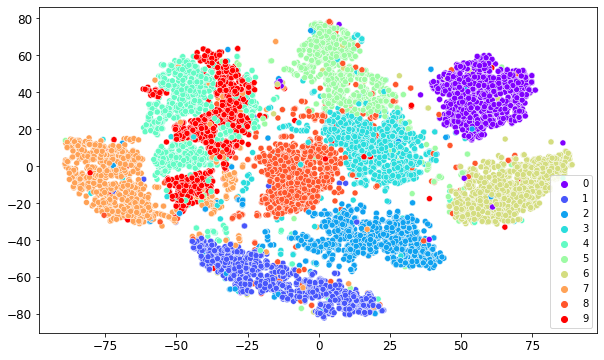

In [121]:
import seaborn as sns

plt.figure(figsize=(10,6))

y_plot = y[:10000]

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], 
                hue=y_plot, palette="rainbow", legend="full")

We can see that there are pretty obvious groups

## Automate Plotting

Let's take our process above and put it in a function that takes a dimensionality reduction algorithm as argument.
<br></br>
The function should do the following:
- Take X, y, DR function as arg
- Apply DR to X and reduce to 2D and get resulting X_reduced
- Plot X_reduced (it's 2 features as x and y axis) with color: label y
    - Scatterplot with color legend

In [122]:
X_plot = X[:10000]

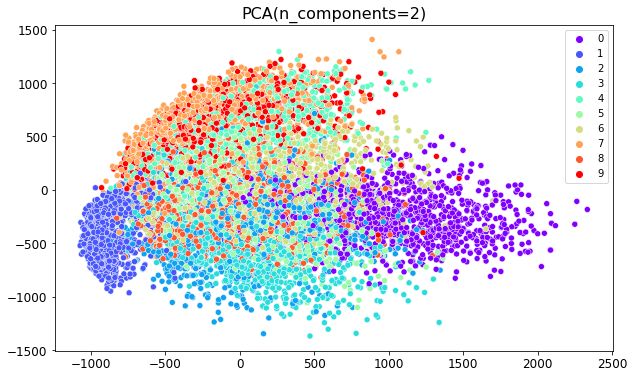

In [126]:
# reduce X to 2D and scatter plot
def visualize_mnist(X, y, reduction_algo):
    X_reduced = reduction_algo.fit_transform(X)
    
    # plot
    plt.figure(figsize=(10,6))
    ax = sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], 
                    hue=y, palette="rainbow", legend="full")
    ax.set_title(reduction_algo, fontsize=16)

visualize_mnist(X_plot, y_plot, PCA(n_components=2))

This one is a lot less clear than t-SNE.

## LLE

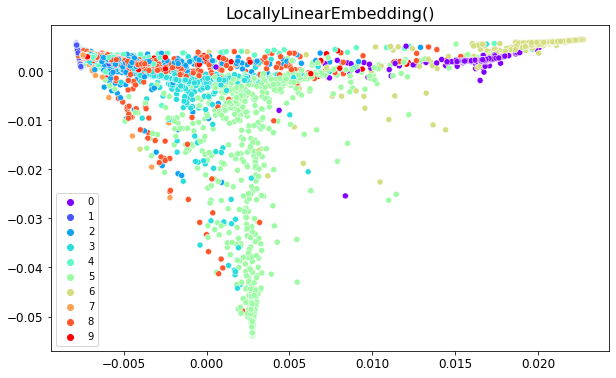

In [127]:
from sklearn.manifold import LocallyLinearEmbedding

visualize_mnist(X_plot, y_plot, LocallyLinearEmbedding(n_components=2))

Wow this is interesting, especially `5`, but I can't really understand the visualization.

## MDS

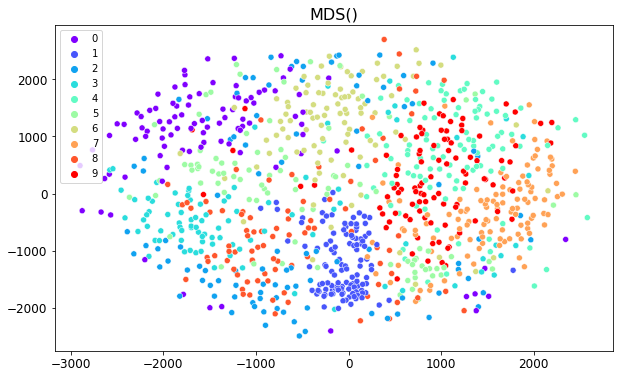

In [129]:
from sklearn.manifold import MDS

visualize_mnist(X_plot[:1000], y_plot[:1000], MDS(n_components=2))

Not very clustered or informative - and slow.

# Comparison to Handsonml

Gerion definitely explored more options:
- He tried applying PCA + another reduction algorithm to see if it would speed up without losing information
- He plotted better
<br></br>

But other than that, I think my code is actually quite good!

In [130]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Gerion using PCA and t-SNE for sped-up visualization without information loss.

In [135]:
mnist.target = mnist.target.astype(np.uint8)

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

/Users/calvinhuang/opt/anaconda3/envs/learningml/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/calvinhuang/opt/anaconda3/envs/learningml/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA+t-SNE took 28.1s.


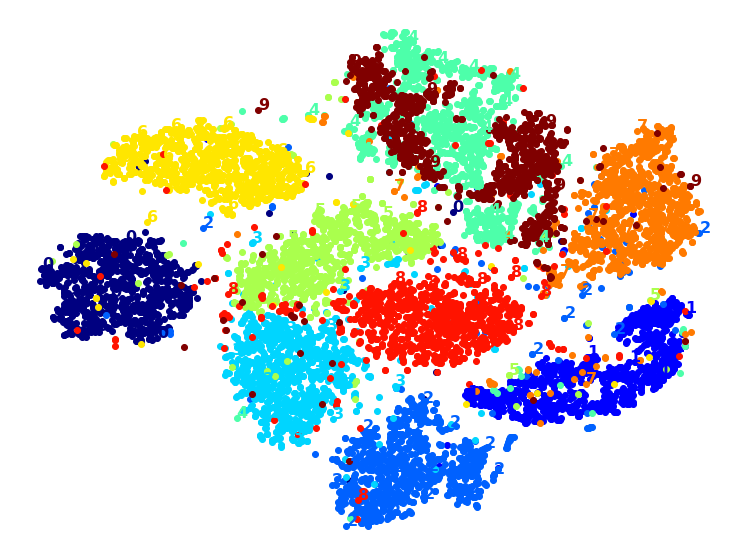

In [136]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Very fast and nicely clustered!